# 🔧 04 - Feature Engineering

**Week 3 Deliverable**: Feature Engineering & Feature Store

## Objectives
1. Create behavioral features from transaction data
2. Engineer time-based features
3. Build comprehensive feature matrix
4. Save feature store for modeling

---

## 1. Setup & Load Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


In [24]:
# Load data
df = pd.read_csv('../data/processed/online_retail_clean.csv', parse_dates=['InvoiceDate'])
rfm = pd.read_csv('../data/features/rfm_segments.csv')

print(f'Transactions: {len(df):,}')
print(f'Customers: {len(rfm):,}')

Transactions: 392,692
Customers: 4,338


## 2. Purchase Pattern Features

In [25]:
# Basic transaction features
purchase_features = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'StockCode': 'nunique',
    'Quantity': ['sum', 'mean', 'std'],
    'UnitPrice': ['mean', 'std', 'max'],
    'Revenue': ['sum', 'mean', 'std', 'max']
})

purchase_features.columns = [
    'total_orders', 'unique_products',
    'total_quantity', 'avg_quantity', 'std_quantity',
    'avg_unit_price', 'std_unit_price', 'max_unit_price',
    'total_revenue', 'avg_revenue', 'std_revenue', 'max_revenue'
]

purchase_features = purchase_features.reset_index()
print(f'Purchase features shape: {purchase_features.shape}')
purchase_features.head()

Purchase features shape: (4338, 13)


,CustomerID,total_orders,unique_products,total_quantity,avg_quantity,std_quantity,avg_unit_price,std_unit_price,max_unit_price,total_revenue,avg_revenue,std_revenue,max_revenue
0,12346,1,1,74215,74215.000000,NaN,1.040000,NaN,1.04,77183.60,77183.600000,NaN,77183.6
1,12347,7,103,2458,13.505495,18.856172,2.644011,2.255381,12.75,4310.00,23.681319,23.289902,249.6
2,12348,4,22,2341,75.516129,51.091990,5.764839,13.400323,40.00,1797.24,57.975484,48.514857,240.0
3,12349,1,73,631,8.643836,6.982856,8.289041,35.028021,300.00,1757.55,24.076027,34.655913,300.0
4,12350,1,17,197,11.588235,4.345383,3.841176,9.334751,40.00,334.40,19.670588,7.275538,40.0


In [26]:
# Items per order
items_per_order = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Quantity': 'sum',
    'StockCode': 'nunique',
    'Revenue': 'sum'
}).reset_index()

basket_features = items_per_order.groupby('CustomerID').agg({
    'Quantity': ['mean', 'std'],
    'StockCode': ['mean', 'std'],
    'Revenue': ['mean', 'std']
})

basket_features.columns = [
    'avg_items_per_order', 'std_items_per_order',
    'avg_unique_products_per_order', 'std_unique_products_per_order',
    'avg_order_value', 'std_order_value'
]

basket_features = basket_features.reset_index()
print(f'Basket features shape: {basket_features.shape}')

Basket features shape: (4338, 7)


## 3. Time-Based Features

In [27]:
# Customer timeline
time_features = df.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max']
})

time_features.columns = ['first_purchase', 'last_purchase']
time_features = time_features.reset_index()

# Customer lifetime (days)
time_features['customer_lifetime_days'] = (time_features['last_purchase'] - time_features['first_purchase']).dt.days

# Days since first purchase
reference_date = df['InvoiceDate'].max() + timedelta(days=1)
time_features['days_since_first'] = (reference_date - time_features['first_purchase']).dt.days

print(f'Time features shape: {time_features.shape}')
time_features.head()

Time features shape: (4338, 5)


,CustomerID,first_purchase,last_purchase,customer_lifetime_days,days_since_first
0,12346,2011-01-18 10:01:00,2011-01-18 10:01:00,0,326
1,12347,2010-12-07 14:57:00,2011-12-07 15:52:00,365,367
2,12348,2010-12-16 19:09:00,2011-09-25 13:13:00,282,358
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0,19
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,0,310


In [28]:
# Inter-purchase time
df_sorted = df.sort_values(['CustomerID', 'InvoiceDate'])
df_sorted['prev_purchase'] = df_sorted.groupby('CustomerID')['InvoiceDate'].shift(1)
df_sorted['days_since_last'] = (df_sorted['InvoiceDate'] - df_sorted['prev_purchase']).dt.days

ipt_features = df_sorted.groupby('CustomerID')['days_since_last'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()

ipt_features.columns = ['CustomerID', 'avg_days_between_purchases', 'std_days_between_purchases', 
                        'min_days_between_purchases', 'max_days_between_purchases']

print(f'Inter-purchase time features shape: {ipt_features.shape}')

Inter-purchase time features shape: (4338, 5)


In [29]:
# Day of week preferences
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month

# Preferred shopping day
preferred_day = df.groupby(['CustomerID', 'DayOfWeek']).size().reset_index(name='count')
preferred_day = preferred_day.loc[preferred_day.groupby('CustomerID')['count'].idxmax()]
preferred_day = preferred_day[['CustomerID', 'DayOfWeek']].rename(columns={'DayOfWeek': 'preferred_day'})

# Weekend vs weekday
df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
weekend_ratio = df.groupby('CustomerID')['is_weekend'].mean().reset_index()
weekend_ratio.columns = ['CustomerID', 'weekend_purchase_ratio']

print(f'Day preferences features created')

Day preferences features created


## 4. Product Diversity Features

In [30]:
# Product diversity
diversity_features = df.groupby('CustomerID').agg({
    'StockCode': 'nunique',
    'Description': 'nunique'
})

diversity_features.columns = ['unique_products', 'unique_descriptions']
diversity_features = diversity_features.reset_index()

# Products per order ratio
diversity_features = diversity_features.merge(
    purchase_features[['CustomerID', 'total_orders']], on='CustomerID'
)
diversity_features['products_per_order'] = diversity_features['unique_products'] / diversity_features['total_orders']

print(f'Diversity features shape: {diversity_features.shape}')

Diversity features shape: (4338, 5)


## 5. Geographic Features

In [31]:
# Country - most common for each customer
country_features = df.groupby('CustomerID')['Country'].agg(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
).reset_index()
country_features.columns = ['CustomerID', 'primary_country']

# Is UK customer (binary feature)
country_features['is_uk'] = (country_features['primary_country'] == 'United Kingdom').astype(int)

print(f'Geographic features shape: {country_features.shape}')
country_features['primary_country'].value_counts().head(10)

Geographic features shape: (4338, 3)


primary_country
United Kingdom    3920
Germany             94
France              87
Spain               29
Belgium             24
Switzerland         20
Portugal            19
Italy               14
Finland             12
Norway              10
Name: count, dtype: int64

## 6. Trend Features

In [32]:
# Monthly revenue trend per customer
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_customer_revenue = df.groupby(['CustomerID', 'YearMonth'])['Revenue'].sum().reset_index()

# Calculate trend (positive = growing, negative = declining)
def calculate_trend(group):
    if len(group) < 2:
        return 0
    x = np.arange(len(group))
    y = group['Revenue'].values
    if np.std(y) == 0:
        return 0
    correlation = np.corrcoef(x, y)[0, 1]
    return correlation if not np.isnan(correlation) else 0

revenue_trend = monthly_customer_revenue.groupby('CustomerID').apply(calculate_trend).reset_index()
revenue_trend.columns = ['CustomerID', 'revenue_trend']

print(f'Trend features shape: {revenue_trend.shape}')

Trend features shape: (4338, 2)


## 7. Build Feature Matrix

In [33]:
# Start with RFM data
feature_matrix = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'Segment']].copy()

# Merge all features
feature_matrix = feature_matrix.merge(purchase_features, on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(basket_features, on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(time_features[['CustomerID', 'customer_lifetime_days', 'days_since_first']], on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(ipt_features, on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(preferred_day, on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(weekend_ratio, on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(diversity_features[['CustomerID', 'unique_products', 'products_per_order']], on='CustomerID', how='left', suffixes=('', '_diversity'))
feature_matrix = feature_matrix.merge(country_features, on='CustomerID', how='left')
feature_matrix = feature_matrix.merge(revenue_trend, on='CustomerID', how='left')

print(f'Feature matrix shape: {feature_matrix.shape}')
feature_matrix.head()

Feature matrix shape: (4338, 39)


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Segment,total_orders,unique_products,total_quantity,avg_quantity,std_quantity,avg_unit_price,std_unit_price,max_unit_price,total_revenue,avg_revenue,std_revenue,max_revenue,avg_items_per_order,std_items_per_order,avg_unique_products_per_order,std_unique_products_per_order,avg_order_value,std_order_value,customer_lifetime_days,days_since_first,avg_days_between_purchases,std_days_between_purchases,min_days_between_purchases,max_days_between_purchases,preferred_day,weekend_purchase_ratio,unique_products_diversity,products_per_order,primary_country,is_uk,revenue_trend
0,12346,326,1,77183.60,1,1,5,Hibernating,1,1,74215,74215.000000,NaN,1.040000,NaN,1.04,77183.60,77183.600000,NaN,77183.6,74215.000000,NaN,1.00,NaN,77183.600000,NaN,0,326,NaN,NaN,NaN,NaN,1,0.000000,1,1.000000,United Kingdom,1,0.000000
1,12347,2,7,4310.00,5,5,5,Champions,7,103,2458,13.505495,18.856172,2.644011,2.255381,12.75,4310.00,23.681319,23.289902,249.6,351.142857,173.277647,26.00,11.430952,615.714286,341.070789,365,367,2.0,11.260551,0.0,90.0,1,0.000000,103,14.714286,Iceland,0,0.028414
2,12348,75,4,1797.24,2,4,4,Loyal Customers,4,22,2341,75.516129,51.091990,5.764839,13.400323,40.00,1797.24,57.975484,48.514857,240.0,585.250000,477.178076,6.75,4.349329,449.310000,301.159918,282,358,9.4,34.088728,0.0,173.0,3,0.096774,22,5.500000,Finland,0,-0.689668
3,12349,19,1,1757.55,4,1,4,New Customers,1,73,631,8.643836,6.982856,8.289041,35.028021,300.00,1757.55,24.076027,34.655913,300.0,631.000000,NaN,73.00,NaN,1757.550000,NaN,0,19,0.0,0.000000,0.0,0.0,0,0.000000,73,73.000000,Italy,0,0.000000
4,12350,310,1,334.40,1,1,2,Hibernating,1,17,197,11.588235,4.345383,3.841176,9.334751,40.00,334.40,19.670588,7.275538,40.0,197.000000,NaN,17.00,NaN,334.400000,NaN,0,310,0.0,0.000000,0.0,0.0,2,0.000000,17,17.000000,Norway,0,0.000000


In [34]:
# Handle missing values
print('Missing values before filling:')
print(feature_matrix.isnull().sum()[feature_matrix.isnull().sum() > 0])

# Fill numeric missing values with median
numeric_cols = feature_matrix.select_dtypes(include=[np.number]).columns
feature_matrix[numeric_cols] = feature_matrix[numeric_cols].fillna(feature_matrix[numeric_cols].median())

print('\nMissing values after filling:')
print(feature_matrix.isnull().sum().sum())

Missing values before filling:
std_quantity                       71
std_unit_price                     71
std_revenue                        71
std_items_per_order              1493
std_unique_products_per_order    1493
std_order_value                  1493
avg_days_between_purchases         71
std_days_between_purchases        125
min_days_between_purchases         71
max_days_between_purchases         71
dtype: int64

Missing values after filling:
0


In [35]:
# Feature summary
print('=== Feature Matrix Summary ===')
print(f'Total customers: {len(feature_matrix):,}')
print(f'Total features: {len(feature_matrix.columns)}')
print(f'\nNumeric features: {len(numeric_cols)}')
print(f'Categorical features: {len(feature_matrix.columns) - len(numeric_cols)}')

=== Feature Matrix Summary ===
Total customers: 4,338
Total features: 39

Numeric features: 37
Categorical features: 2


## 8. Feature Analysis

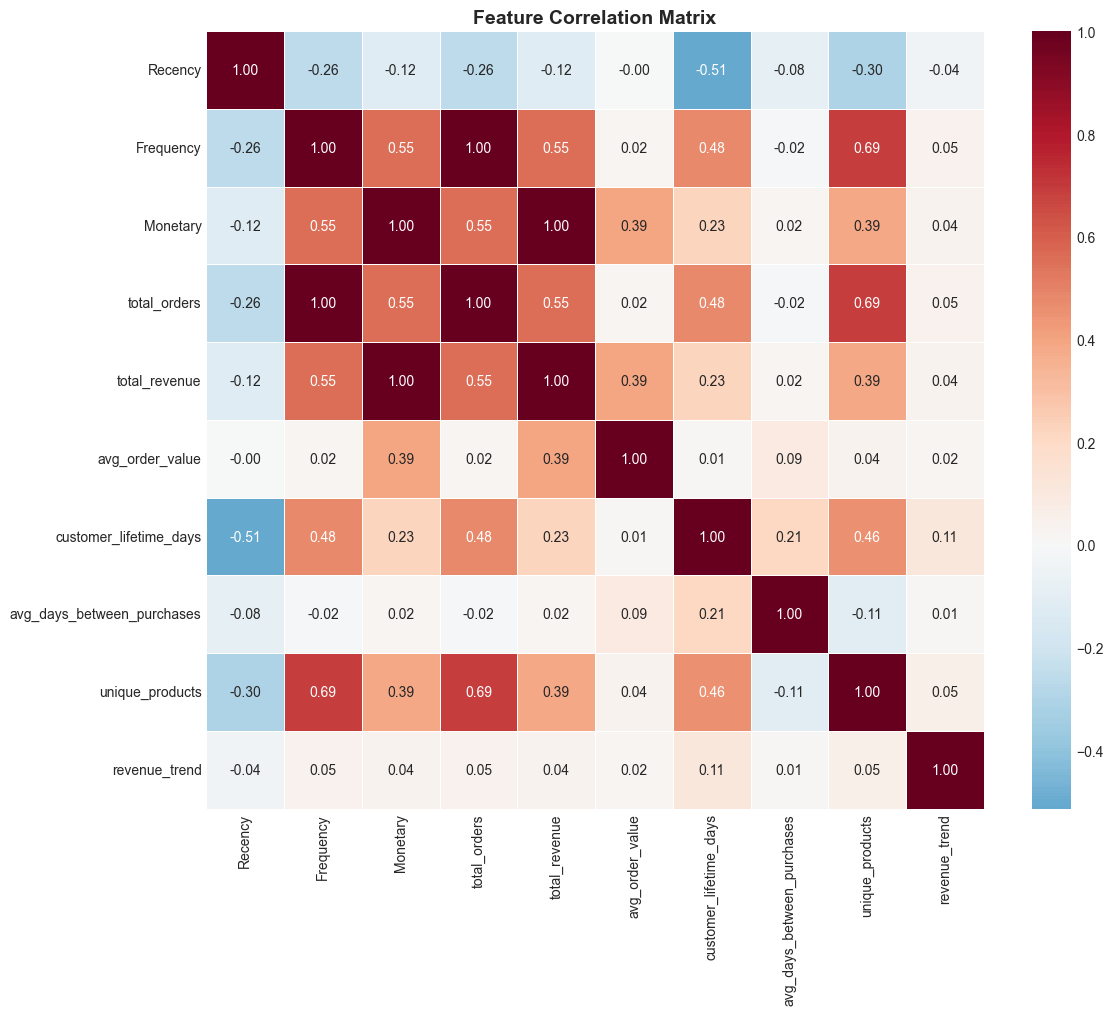

In [36]:
# Correlation matrix
correlation_cols = ['Recency', 'Frequency', 'Monetary', 'total_orders', 'total_revenue',
                   'avg_order_value', 'customer_lifetime_days', 'avg_days_between_purchases',
                   'unique_products', 'revenue_trend']

corr_matrix = feature_matrix[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/features/feature_correlation.png', dpi=300)
plt.show()

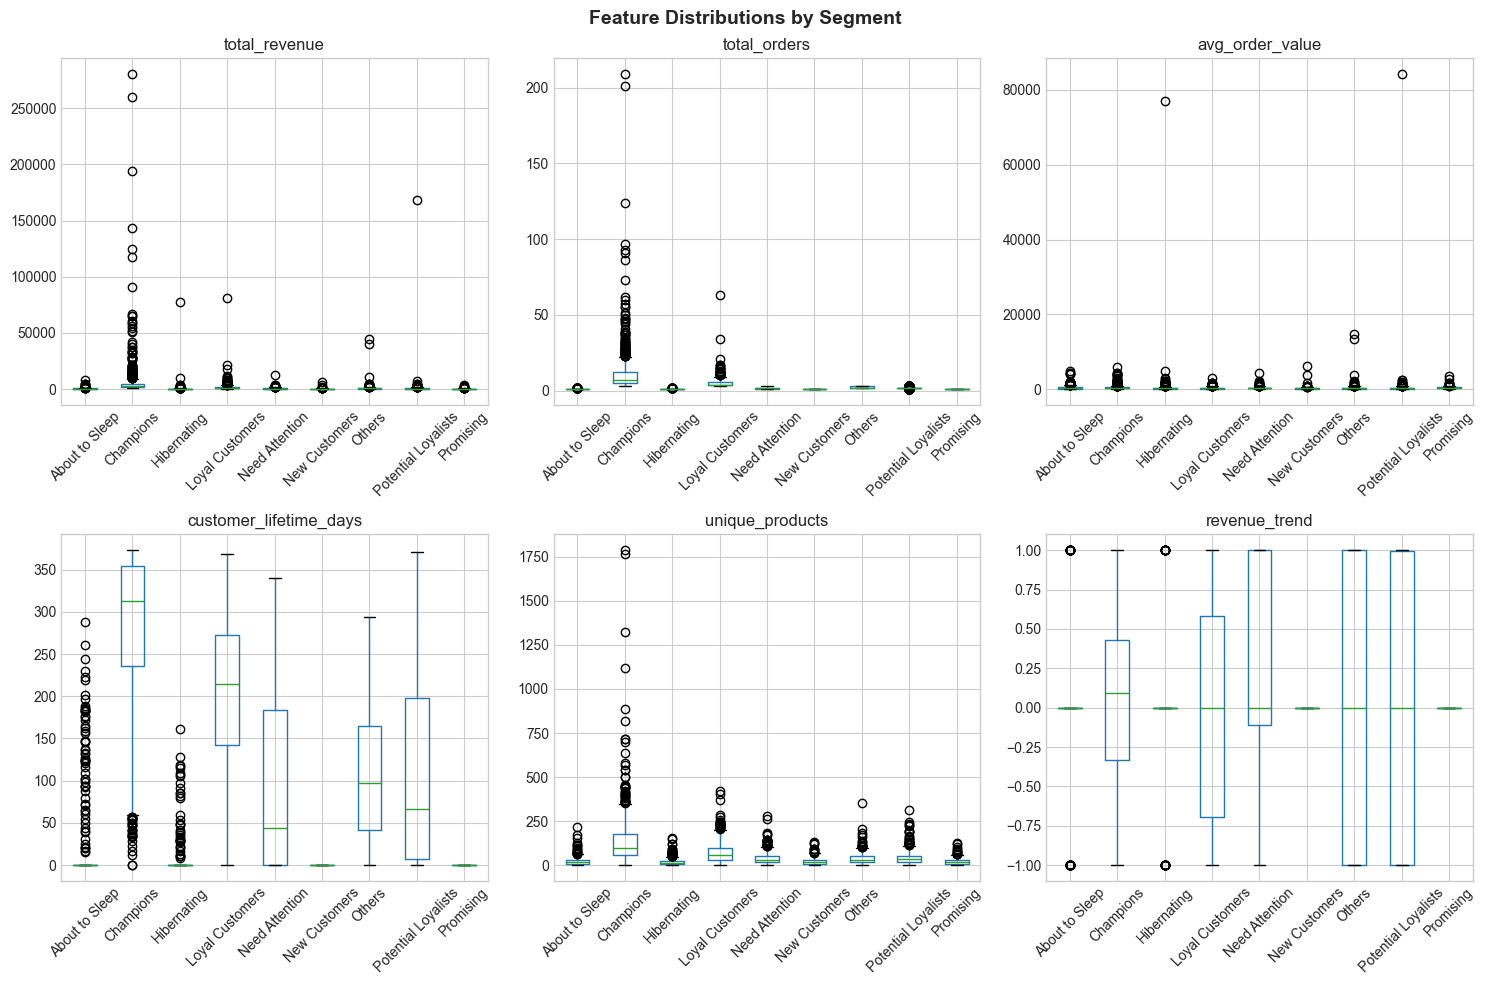

In [37]:
# Feature distributions by segment
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features_to_plot = ['total_revenue', 'total_orders', 'avg_order_value', 
                    'customer_lifetime_days', 'unique_products', 'revenue_trend']

for ax, feature in zip(axes.flatten(), features_to_plot):
    feature_matrix.boxplot(column=feature, by='Segment', ax=ax, rot=45)
    ax.set_title(feature)
    ax.set_xlabel('')

plt.suptitle('Feature Distributions by Segment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../data/features/feature_distributions.png', dpi=300)
plt.show()

## 9. Create Scaled Features

In [38]:
# Select features for modeling
modeling_features = [
    'Recency', 'Frequency', 'Monetary',
    'total_orders', 'total_quantity', 'total_revenue',
    'avg_quantity', 'avg_unit_price', 'avg_revenue', 'max_revenue',
    'avg_items_per_order', 'avg_order_value',
    'customer_lifetime_days', 'days_since_first',
    'avg_days_between_purchases',
    'unique_products', 'products_per_order',
    'weekend_purchase_ratio', 'revenue_trend'
]

# Ensure all features exist
modeling_features = [f for f in modeling_features if f in feature_matrix.columns]

print(f'Features for modeling: {len(modeling_features)}')

Features for modeling: 19


In [39]:
# Standard scaling
scaler = StandardScaler()

scaled_features = pd.DataFrame(
    scaler.fit_transform(feature_matrix[modeling_features]),
    columns=[f'{col}_scaled' for col in modeling_features]
)

# Add scaled features to matrix
feature_matrix_full = pd.concat([feature_matrix, scaled_features], axis=1)

print(f'Full feature matrix shape: {feature_matrix_full.shape}')

Full feature matrix shape: (4338, 58)


## 10. Save Feature Store

In [40]:
# Save feature matrix
feature_matrix.to_csv('../data/features/feature_matrix.csv', index=False)
feature_matrix_full.to_csv('../data/features/feature_matrix_full.csv', index=False)

# Save feature list
feature_info = pd.DataFrame({
    'feature': modeling_features,
    'type': ['numeric'] * len(modeling_features)
})
feature_info.to_csv('../data/features/feature_info.csv', index=False)

print('Feature store saved!')
print('  - feature_matrix.csv')
print('  - feature_matrix_full.csv')
print('  - feature_info.csv')

Feature store saved!
  - feature_matrix.csv
  - feature_matrix_full.csv
  - feature_info.csv


In [41]:
print('=' * 60)
print('FEATURE ENGINEERING - SUMMARY')
print('=' * 60)

print(f'\n Feature Matrix:')
print(f'   • Customers: {len(feature_matrix):,}')
print(f'   • Total features: {len(feature_matrix.columns)}')
print(f'   • Modeling features: {len(modeling_features)}')

print(f'\n Feature Categories:')
print(f'   • RFM features: 6')
print(f'   • Purchase pattern: 12')
print(f'   • Time-based: 5')
print(f'   • Diversity: 3')
print(f'   • Trend: 1')

print('\n' + '=' * 60)

FEATURE ENGINEERING - SUMMARY

 Feature Matrix:
   • Customers: 4,338
   • Total features: 39
   • Modeling features: 19

 Feature Categories:
   • RFM features: 6
   • Purchase pattern: 12
   • Time-based: 5
   • Diversity: 3
   • Trend: 1



## Next Steps

Continue to **Notebook 05 - CLV Modeling** to:
- Build probabilistic CLV models (BG/NBD, Gamma-Gamma)
- Train machine learning CLV models
- Compare model performance